In [29]:
import os
import glob
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [30]:
# loading numeric dataset
NUMERIC = "/home/karina/code/ADNIMERGE.csv"
# Load the CSV data
csv_data = pd.read_csv(NUMERIC)

/tmp/ipykernel_22516/91674609.py:4: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(NUMERIC)


In [75]:
# Load specific columns from the CSV file
columns_to_include = ["PTID", "DX_bl", "AGE", "PTGENDER", "PTRACCAT", "APOE4", "ABETA", "TAU", "PTAU", "DX"]
csv_data_clean = pd.read_csv(NUMERIC, usecols=columns_to_include)

# Drop rows with any missing values
#csv_data_clean.dropna(inplace=True)

# adding label if AD or not (yes AD = 1, no AD = 0)
csv_data_clean['AD_Label'] = csv_data_clean['DX_bl'].apply(lambda x: 1 if x == 'AD' else 0)

# Display the cleaned data to verify
print(csv_data_clean.head(10))

         PTID DX_bl   AGE PTGENDER PTRACCAT  APOE4   ABETA    TAU   PTAU  \
0  011_S_0002    CN  74.3     Male    White    0.0     NaN    NaN    NaN   
1  011_S_0003    AD  81.3     Male    White    1.0   741.5  239.7  22.83   
2  011_S_0003    AD  81.3     Male    White    1.0     NaN    NaN    NaN   
3  011_S_0003    AD  81.3     Male    White    1.0   601.4  251.7  24.18   
4  011_S_0003    AD  81.3     Male    White    1.0     NaN    NaN    NaN   
5  022_S_0004  LMCI  67.5     Male    White    0.0  1501.0  153.1  13.29   
6  022_S_0004  LMCI  67.5     Male    White    0.0     NaN    NaN    NaN   
7  022_S_0004  LMCI  67.5     Male    White    0.0  1176.0  159.7   13.3   
8  022_S_0004  LMCI  67.5     Male    White    0.0     NaN    NaN    NaN   
9  022_S_0004  LMCI  67.5     Male    White    0.0     NaN    NaN    NaN   

         DX  AD_Label  
0        CN         0  
1  Dementia         1  
2  Dementia         1  
3  Dementia         1  
4  Dementia         1  
5       MCI        

/tmp/ipykernel_22516/3782779313.py:3: DtypeWarning: Columns (18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data_clean = pd.read_csv(NUMERIC, usecols=columns_to_include)


In [60]:
csv_data_clean.shape

(13915, 11)

In [63]:
# loading dataset
DATASET = "/data/datasets/AD/AD_jpgs/Total/"

# Create a dictionary that maps PTID to all the data related to each patient
ptid_data = {str(row["PTID"]): row.to_dict() for _, row in csv_data_clean.iterrows()}

Patient ID: 114_S_0601
PTID: 114_S_0601
DX_bl: CN
AGE: 76.6
PTGENDER: Female
PTRACCAT: White
APOE4: 0.0
ABETA: nan
TAU: nan
PTAU: nan
DX: nan
AD_Label: 0


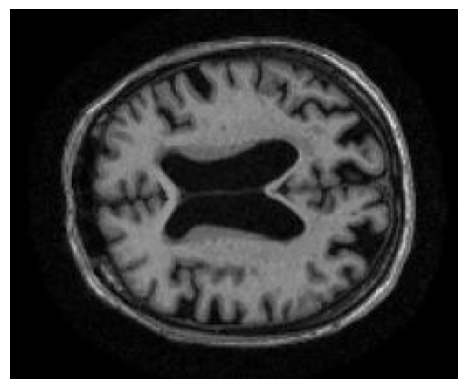

In [99]:
# Load all image paths
image_paths = glob.glob(os.path.join(DATASET, "*.jpg"))

# Select any image for testing 
image_path = image_paths[132]  
image = Image.open(image_path).convert("RGB")

# Extract patient ID from the image filename 
ptid = os.path.splitext(os.path.basename(image_path))[0]

# Retrieve patient information for the given PTID
patient_info = ptid_data.get(ptid, {})

# Print patient ID and associated information
print(f"Patient ID: {ptid}")
for column, value in patient_info.items():
    print(f"{column}: {value}")

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

In [100]:
BATCH_SIZE = 32 
NUM_CLIENTS = 10  # Number of clients for federated learning

# Set a seed for reproducibility
random.seed(42)


# handle loading of images to be a format that PyTorch can use for training and testing
class BrainImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    # returns number of images in dataset
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

def load_datasets():
    # Load all images which are jpg
    image_paths = glob.glob(os.path.join(DATASET, "*.jpg"))
    # ensures no bias
    random.seed(42)
    random.shuffle(image_paths)

    # Split data into 10 partitions
    partition_size = len(image_paths) // NUM_CLIENTS # how many images each client will get
    partitions = defaultdict(list) # store image file paths for each client

    for i in range(NUM_CLIENTS):
        start_index = i * partition_size
        if i == NUM_CLIENTS - 1:  # Ensure the last partition gets all remaining images in case not even
            partitions[i] = image_paths[start_index:]
        else:
            partitions[i] = image_paths[start_index:start_index + partition_size] # each partition gets a list of client images

    # Create PyTorch DataLoaders for each partition
    pytorch_transforms = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize images
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  
    ])
    
    trainloaders, testloaders = {}, {}
    for client_id, images in partitions.items():
        # Split images into 80% train, 20% test
        split_index = int(len(images) * 0.8)
        train_images = images[:split_index]
        test_images = images[split_index:]

        trainloaders[client_id] = DataLoader(BrainImageDataset(train_images, transform=pytorch_transforms), batch_size=BATCH_SIZE, shuffle=False)
        testloaders[client_id] = DataLoader(BrainImageDataset(test_images, transform=pytorch_transforms), batch_size=BATCH_SIZE, shuffle=False)

    return trainloaders, testloaders

In [101]:
BATCH_SIZE = 32 
NUM_CLIENTS = 10  # Number of clients for federated learning

# Set a seed for reproducibility
random.seed(42)

# Dataset class for loading images and their labels
class BrainImageDataset(Dataset):
    def __init__(self, image_paths, ptid_data, transform=None):
        self.image_paths = image_paths
        self.ptid_data = ptid_data  # Store the mapping from PTID to patient data
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        ptid = os.path.basename(image_path).split('.')[0]  # Extract PTID from the file name
        label = self.ptid_data.get(ptid, {}).get('AD_Label', 0)  # Default to 0 if PTID not found

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

def load_datasets(partition_id=0):
    # Load all images which are jpg
    image_paths = glob.glob(os.path.join(DATASET, "*.jpg"))
    random.shuffle(image_paths)

    # Split data into 10 partitions
    partition_size = len(image_paths) // NUM_CLIENTS  # Number of images each client will get
    partitions = defaultdict(list)  # Store image file paths for each client

    for i in range(NUM_CLIENTS):
        start_index = i * partition_size
        if i == NUM_CLIENTS - 1:  # Ensure the last partition gets all remaining images
            partitions[i] = image_paths[start_index:]
        else:
            partitions[i] = image_paths[start_index:start_index + partition_size]

    # Create PyTorch DataLoaders for each partition
    pytorch_transforms = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize images
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize grayscale images, you may adjust based on needs
    ])
    
    partition_images = partitions[partition_id]  # Get the images for this client
    # Split data into 80% train, 20% test
    split_index = int(len(partition_images) * 0.8)
    train_images = partition_images[:split_index]
    test_images = partition_images[split_index:]

    # Create DataLoader for train and test sets
    trainloader = DataLoader(BrainImageDataset(train_images, ptid_data, transform=pytorch_transforms), batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(BrainImageDataset(test_images, ptid_data, transform=pytorch_transforms), batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, testloader


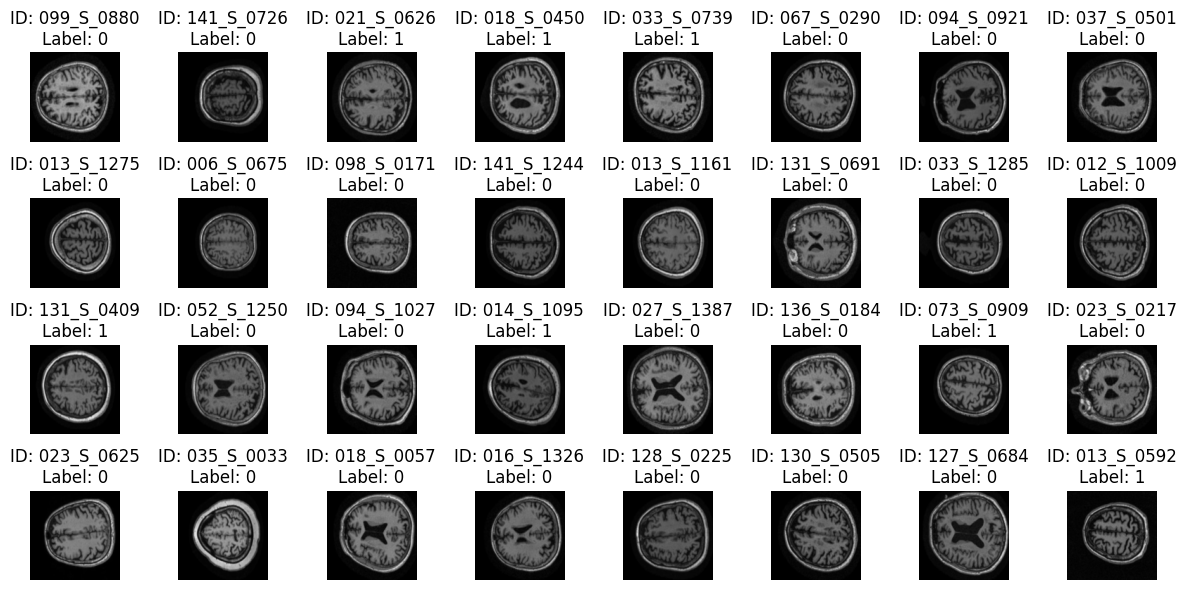

In [81]:
# Load the datasets for partition 0
trainloader, testloader = load_datasets(partition_id=0)

# Get the first batch of data from the trainloader
batch = next(iter(trainloader))  # Get the first batch of data
images, labels = batch  # Extract the images and labels

# Reshape and convert images to a NumPy array
images = images.permute(0, 2, 3, 1).numpy()  # Convert from (B, C, H, W) to (B, H, W, C)

# Denormalize the images if they were normalized
images = images / 2 + 0.5  # Undo the normalization

# Create a figure and a grid of subplots (4 rows x 8 columns)
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])  # Display the image
    ptid = os.path.basename(trainloader.dataset.image_paths[i]).split('.')[0]  # Extract PTID
    label = labels[i].item()  # Get the label for the image
    ax.set_title(f"ID: {ptid}\nLabel: {label}")  # Display PTID and label in the title
    ax.axis("off")  # Hide axis

# Show the plot
fig.tight_layout()
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [102]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        # First convolutional layer: input channels = 3 (RGB), output channels = 6, kernel size = 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max-pooling layer: pool size = 2, stride = 2
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: input channels = 6, output channels = 16, kernel size = 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        self.fc1 = None  # Will define later after calculating the size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Output 2 classes: AD vs. Non-AD

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply first convolutional layer + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolutional layer + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv2(x)))

        # Dynamically calculate the size of the flattened layer
        x = x.view(x.size(0), -1)  # Flatten the tensor to a vector
        if self.fc1 is None:  # If the size of fc1 is not set
            self.fc1 = nn.Linear(x.size(1), 120)  # Define the first fully connected layer
            self.fc2 = nn.Linear(120, 84)  # Define the second fully connected layer

        # Apply fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer (logits for the classes)
        x = self.fc3(x)
        return x

In [103]:
# Define the train function
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# Define the test function
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [111]:
# Loading datasets and partitioning them (modify according to actual function behavior)
trainloader, testloader = load_datasets(partition_id=0)  # Assuming load_datasets only returns train and test loaders
net = Net().to(DEVICE)  # Initialize the model and move it to the device

# Training loop
for epoch in range(5):
    train(net, trainloader, 1, verbose=True)  # Train for 1 epoch at a time
    
# Evaluate on the test set after training
loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Epoch 1: train loss 0.021122231148183346, accuracy 0.65625
Epoch 1: train loss 0.02059278544038534, accuracy 0.65625
Epoch 1: train loss 0.022311482578516006, accuracy 0.65625
Epoch 1: train loss 0.02089445386081934, accuracy 0.65625
Epoch 1: train loss 0.019504291005432606, accuracy 0.65625
Final test set performance:
	loss 0.033878820783951706
	accuracy 0.7647058823529411
